In [1]:
%pip install 'chronos-forecasting>=2.0' 'pandas[pyarrow]' 'matplotlib' --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

# Use only 1 GPU if available
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    # device_map="cuda"
        device_map="cpu")

In [3]:
import pandas as pd
import holidays

def add_holiday_flags(
    df: pd.DataFrame,
    ts_col: str = "ds",
    local_tz: str = "America/Montreal",
    observed: bool = True,
    include_names: bool = False,
) -> pd.DataFrame:
    """
    Adds boolean columns:
      • is_qc_holiday       — Québec public holiday (CA-QC)
      • is_jewish_holiday   — Israeli public/Jewish holiday (IL)
    Optionally adds:
      • qc_holiday_name
      • jewish_holiday_name

    Notes:
      • Holiday checks are date-based (00:00–24:00 local calendar date),
        not sundown-to-sundown observance.
      • NaT timestamps are ignored gracefully.
    """
    out = df.copy()

    # 1) Parse to datetime
    out[ts_col] = pd.to_datetime(out[ts_col], errors="coerce")

    # 2) Get the calendar DATE to use for holiday lookup
    #    - If tz-aware: convert to Montreal then take .date
    #    - If naive: assume values already represent local Montreal wall-clock; just take .date
    if getattr(out[ts_col].dt, "tz", None) is not None:
        dates_for_calendar = out[ts_col].dt.tz_convert(local_tz).dt.date
    else:
        dates_for_calendar = out[ts_col].dt.date

    # 3) Build a SAFE integer year range for the holiday objects
    years_series = pd.Series(dates_for_calendar)
    years_series = years_series.dropna().map(lambda d: int(pd.Timestamp(d).year))
    if years_series.empty:
        raise ValueError("No valid datetimes found to extract holiday years.")
    years = list(range(int(years_series.min()), int(years_series.max()) + 1))

    # 4) Construct holiday calendars
    qc_holidays = holidays.Canada(subdiv="QC", years=years, observed=observed)
    il_holidays = holidays.Israel(years=years, observed=observed)

    # 5) Flag membership
    out["is_qc_holiday"] = [ (d in qc_holidays) if pd.notna(pd.Timestamp(d)) else False
                             for d in dates_for_calendar ]
    out["is_jewish_holiday"] = [ (d in il_holidays) if pd.notna(pd.Timestamp(d)) else False
                                 for d in dates_for_calendar ]

    if include_names:
        out["qc_holiday_name"] = [ qc_holidays.get(d, "") if pd.notna(pd.Timestamp(d)) else ""
                                   for d in dates_for_calendar ]
        out["jewish_holiday_name"] = [ il_holidays.get(d, "") if pd.notna(pd.Timestamp(d)) else ""
                                       for d in dates_for_calendar ]

    return out


In [43]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/s83jig4zews1xz7vhezui/allDataWithCalculatedColumns.csv?rlkey=9mm4zwaugxyj2r4ooyd39y4nl&raw=1')
df.ds = pd.to_datetime(df.ds, errors="coerce")
df.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_CONS_MORE2H,RAZ_IMCONS_MORE4H,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow
42577,2025-11-13 09:00:00,10,43,6,16,16,59,3,14,0,...,3,0,0,0,17,12,19,15,4,5
42578,2025-11-13 10:00:00,14,57,8,24,22,81,1,15,0,...,2,0,0,0,17,12,28,23,5,5
42579,2025-11-13 11:00:00,15,72,3,27,18,99,6,21,1,...,5,0,0,1,17,12,23,18,5,9
42580,2025-11-13 12:00:00,16,88,6,33,22,121,2,23,1,...,12,0,0,2,16,11,35,21,14,18
42581,2025-11-13 13:00:00,10,98,7,40,17,138,2,25,0,...,12,0,0,1,12,8,32,20,12,15


In [44]:
df = add_holiday_flags(df, ts_col="ds")
df.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_XRAY_MORE2H,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,is_qc_holiday,is_jewish_holiday
42577,2025-11-13 09:00:00,10,43,6,16,16,59,3,14,0,...,0,0,17,12,19,15,4,5,False,False
42578,2025-11-13 10:00:00,14,57,8,24,22,81,1,15,0,...,0,0,17,12,28,23,5,5,False,False
42579,2025-11-13 11:00:00,15,72,3,27,18,99,6,21,1,...,0,1,17,12,23,18,5,9,False,False
42580,2025-11-13 12:00:00,16,88,6,33,22,121,2,23,1,...,0,2,16,11,35,21,14,18,False,False
42581,2025-11-13 13:00:00,10,98,7,40,17,138,2,25,0,...,0,1,12,8,32,20,12,15,False,False


In [45]:
df['id']='jgh'
df.head()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,RAZ_CT_MORE2H1,PSYCH1,PSYCH_WAITINGADM,total_tbs,vert_tbs,pod_tbs,overflow,is_qc_holiday,is_jewish_holiday,id
0,2021-01-01 01:00:00,1,1,1,1,2,2,0,0,0,...,0,3,3,0,0,0,0,True,False,jgh
1,2021-01-01 02:00:00,2,3,1,2,3,5,1,1,0,...,0,3,3,3,2,1,0,True,False,jgh
2,2021-01-01 03:00:00,0,3,1,3,1,6,0,1,0,...,0,3,3,2,1,1,0,True,False,jgh
3,2021-01-01 04:00:00,1,4,0,3,1,7,1,2,0,...,0,4,3,1,0,1,0,True,False,jgh
4,2021-01-01 05:00:00,1,5,1,4,2,9,1,3,0,...,0,4,3,2,1,1,0,True,False,jgh


In [46]:
import pandas as pd
from pandas.tseries.frequencies import to_offset

ID_COL = "id"
TS_COL = "ds"
TARGETS = ['total_tbs','overflow','Inflow_Total']

df = df.copy()
df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce")
df = df.dropna(subset=[TS_COL])

# Snap to exact hours (lowercase 'h' to avoid FutureWarning)
df[TS_COL] = df[TS_COL].dt.floor("h")

# Sort + dedupe
df = df.sort_values([ID_COL, TS_COL]).drop_duplicates([ID_COL, TS_COL], keep="last")

def regularize_hourly(g: pd.DataFrame) -> pd.DataFrame:
    """
    Reindex each group's timestamps to strict hourly and fill gaps.
    Works whether the grouping column is present or omitted (include_groups=False).
    """
    # The group key (id) is available as g.name; if ID_COL exists, prefer it.
    sid = g[ID_COL].iloc[0] if ID_COL in g.columns else g.name

    g = g.sort_values(TS_COL)
    full_idx = pd.date_range(g[TS_COL].min(), g[TS_COL].max(), freq="h")
    g = g.set_index(TS_COL).reindex(full_idx)
    g.index.name = TS_COL

    # restore id (constant for the whole group)
    g[ID_COL] = sid

    # numeric + fill for targets
    for col in TARGETS:
        if col in g.columns:
            g[col] = pd.to_numeric(g[col], errors="coerce").ffill().bfill()
    return g.reset_index()

# Call apply with include_groups=False if supported; else fall back
gb = df.groupby(ID_COL, group_keys=False)
try:
    df = gb.apply(regularize_hourly, include_groups=False)
except TypeError:
    # older pandas without include_groups
    df = gb.apply(regularize_hourly)

# Assert truly hourly (accept 'h' and 'H')
g = df[df[ID_COL] == "jgh"].sort_values(TS_COL)
freq = pd.infer_freq(g[TS_COL])
if not freq:
    raise ValueError("No inferable frequency after regularization.")
if to_offset(freq).name.lower() != "h":
    # extra check independent of infer_freq
    diffs = g[TS_COL].diff().dropna()
    bad = g.loc[diffs != pd.Timedelta(hours=1), TS_COL].head(10).tolist()
    raise ValueError(f"Non-1h gaps remain around: {bad}")



In [47]:
# Predict
pred_df = pipeline.predict_df(
    df,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
pred_df.head()

,id,ds,target_name,predictions,0.1,0.5,0.9
0,jgh,2025-11-13 14:00:00,total_tbs,34.352543,29.009174,34.352543,39.896183
1,jgh,2025-11-13 15:00:00,total_tbs,34.485626,26.940626,34.485626,41.955490
2,jgh,2025-11-13 16:00:00,total_tbs,37.399147,27.814247,37.399147,46.632229
3,jgh,2025-11-13 17:00:00,total_tbs,32.291466,21.864510,32.291466,43.140415
4,jgh,2025-11-13 18:00:00,total_tbs,29.914062,18.557995,29.914062,41.946289


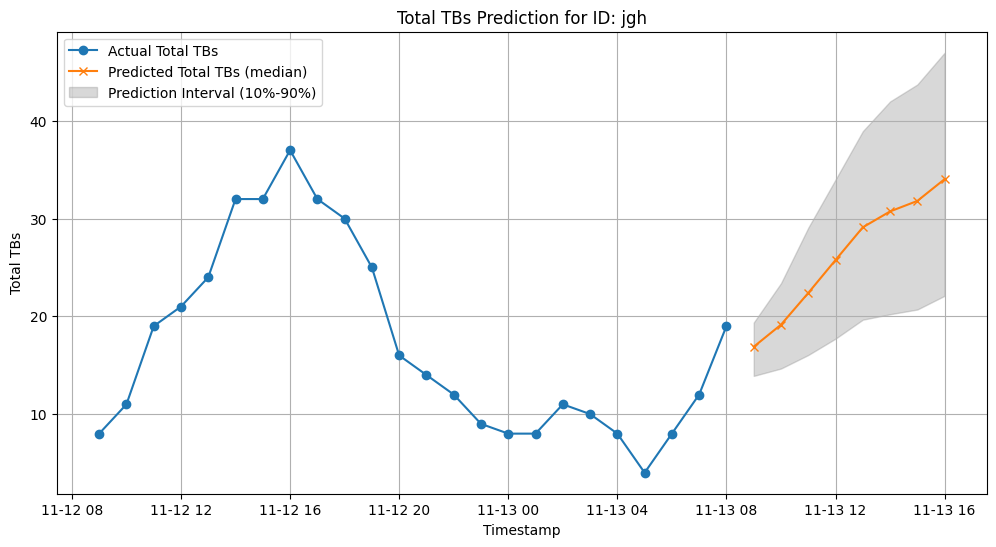

In [23]:
# make a graph of the next 8 hours of predictions of total_tbs, along with the last 24 hours of actual total_tbs
# (matplotlib is already imported earlier in the notebook; no need to re-import)
# Filter for the specific id and target_name == 'total_tbs'
id_to_plot = "jgh"
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)

# pred_df stores quantiles in columns '0.1','0.5','0.9' and has a 'target_name' column.
predicted_data = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "total_tbs")
].set_index(TS_COL)

# Ensure predicted rows are sorted by timestamp
predicted_data = predicted_data.sort_index()

# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["total_tbs"][-24:], label="Actual Total TBs", marker="o")

# Plot the next 8 hours of predicted median (0.5) and fill 10%-90% interval
plt.plot(predicted_data.index[:8], predicted_data["0.5"][:8], label="Predicted Total TBs (median)", marker="x")
plt.fill_between(
    predicted_data.index[:8],
    predicted_data["0.1"][:8],
    predicted_data["0.9"][:8],
    color="gray",
    alpha=0.3,
    label="Prediction Interval (10%-90%)",
)

plt.xlabel("Timestamp")
plt.ylabel("Total TBs")
plt.title(f"Total TBs Prediction for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()


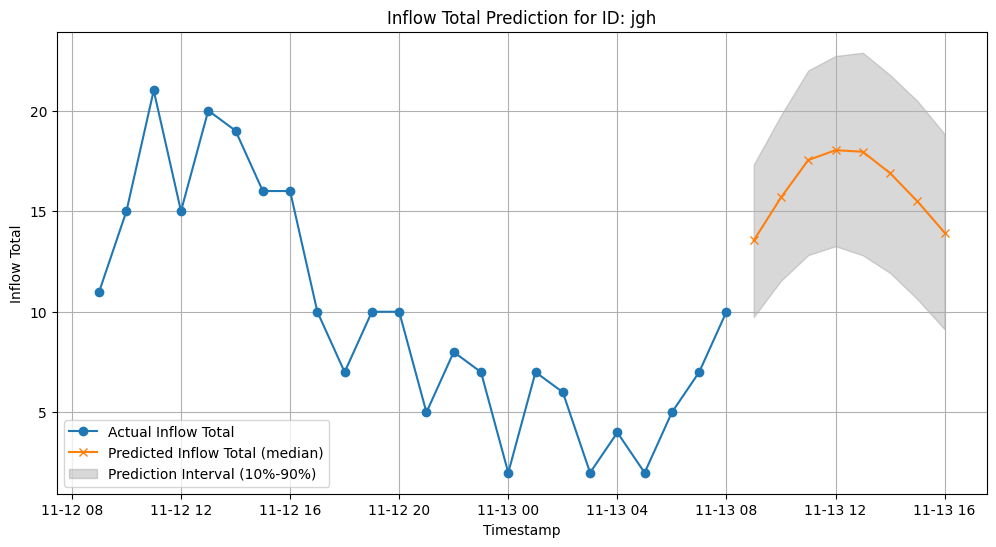

In [24]:
#plot the last 24 hours of Inflow_Total, along with the next 8 hours of predictions
# Filter for the specific id and target_name == 'Inflow_Total'
id_to_plot = "jgh"
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "Inflow_Total")
].set_index(TS_COL)
# Ensure predicted rows are sorted by timestamp
predicted_data = predicted_data.sort_index()    
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["Inflow_Total"][-24:], label="Actual Inflow Total", marker="o")
# Plot the next 8 hours of predicted median (0.5) and fill 10%-90% interval
plt.plot(predicted_data.index[:8], predicted_data["0.5"][:8], label="Predicted Inflow Total (median)", marker="x")
plt.fill_between(
    predicted_data.index[:8],
    predicted_data["0.1"][:8],
    predicted_data["0.9"][:8],
    color="gray",
    alpha=0.3,
    label="Prediction Interval (10%-90%)",
)
plt.xlabel("Timestamp")
plt.ylabel("Inflow Total")
plt.title(f"Inflow Total Prediction for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()

In [48]:
metar_df = pd.read_csv(
    'https://www.dropbox.com/scl/fi/7b390c7zu7lg2nug9r21e/full_metar_data.csv?rlkey=ob25xfgvuqth42lruczhszoz3&raw=1')
metar_df['ds'] = pd.to_datetime(metar_df.valid, format="mixed", errors='coerce')
metar_df.tail()

,station,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,...,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth,ds
42507,CYUL,2025-11-13 09:00,33.8,32.0,93.02,240.00,3.0,0.0,29.73,1007.2,...,M,M,M,M,M,M,30.75,CYUL 131400Z 24003KT 2SM -SNRA BKN007 OVC012 0...,M,2025-11-13 09:00:00
42508,CYUL,2025-11-13 10:00,33.8,32.0,93.02,250.00,4.0,0.0,29.74,1007.6,...,M,M,M,M,M,M,29.52,CYUL 131500Z 25004KT 1 1/2SM -SN BKN004 OVC024...,M,2025-11-13 10:00:00
42509,CYUL,2025-11-13 11:00,33.8,33.8,100.00,270.00,5.0,0.0,29.75,1007.7,...,M,M,M,M,M,M,28.53,CYUL 131600Z 27005KT 2SM -SNRA BKN005 OVC032 0...,M,2025-11-13 11:00:00
42510,CYUL,2025-11-13 12:00,35.6,33.8,93.08,280.00,9.0,0.0,29.75,1007.8,...,M,M,M,M,M,M,27.99,CYUL 131700Z 28009KT 3SM -DZ BR OVC007 02/01 A...,M,2025-11-13 12:00:00
42511,CYUL,2025-11-13 13:00,35.6,33.8,93.08,300.00,7.0,0.0,29.76,1008.3,...,M,M,M,M,M,M,29.17,CYUL 131800Z 30007KT 3SM -RA BR OVC008 02/01 A...,M,2025-11-13 13:00:00


In [49]:
target_metar_columns = ['tmpf',
 'dwpf',
 'relh',
 'drct',
 'sknt',
 'p01i',
 'alti',
 'mslp',
 'vsby',
 'gust',
 'skyc1',
 'skyc2',
 'skyc3',
 'skyc4',
 'skyl1',
 'skyl2',
 'skyl3',
 'skyl4',
 'wxcodes',
 'ice_accretion_1hr',
 'ice_accretion_3hr',
 'ice_accretion_6hr',
 'peak_wind_gust',
 'peak_wind_drct',
 'peak_wind_time',
 'feel',
#  'metar',
 'snowdepth',
 'ds']

metar_df = metar_df[target_metar_columns]
metar_df.tail()

,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,...,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,snowdepth,ds
42507,33.8,32.0,93.02,240.00,3.0,0.0,29.73,1007.2,2.0,M,...,-SNRA,M,M,M,M,M,M,30.75,M,2025-11-13 09:00:00
42508,33.8,32.0,93.02,250.00,4.0,0.0,29.74,1007.6,1.5,M,...,-SN,M,M,M,M,M,M,29.52,M,2025-11-13 10:00:00
42509,33.8,33.8,100.00,270.00,5.0,0.0,29.75,1007.7,2.0,M,...,-SNRA,M,M,M,M,M,M,28.53,M,2025-11-13 11:00:00
42510,35.6,33.8,93.08,280.00,9.0,0.0,29.75,1007.8,3.0,M,...,-DZ BR,M,M,M,M,M,M,27.99,M,2025-11-13 12:00:00
42511,35.6,33.8,93.08,300.00,7.0,0.0,29.76,1008.3,3.0,M,...,-RA BR,M,M,M,M,M,M,29.17,M,2025-11-13 13:00:00


In [50]:
#join metar_df to df on ds column
df_with_hist_weather = pd.merge(df, metar_df, on='ds', how='left')
df_with_hist_weather.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,snowdepth
42689,2025-11-13 09:00:00,10.0,43.0,6.0,16.0,16.0,59.0,3.0,14.0,0.0,...,M,-SNRA,M,M,M,M,M,M,30.75,M
42690,2025-11-13 10:00:00,14.0,57.0,8.0,24.0,22.0,81.0,1.0,15.0,0.0,...,M,-SN,M,M,M,M,M,M,29.52,M
42691,2025-11-13 11:00:00,15.0,72.0,3.0,27.0,18.0,99.0,6.0,21.0,1.0,...,M,-SNRA,M,M,M,M,M,M,28.53,M
42692,2025-11-13 12:00:00,16.0,88.0,6.0,33.0,22.0,121.0,2.0,23.0,1.0,...,M,-DZ BR,M,M,M,M,M,M,27.99,M
42693,2025-11-13 13:00:00,10.0,98.0,7.0,40.0,17.0,138.0,2.0,25.0,0.0,...,M,-RA BR,M,M,M,M,M,M,29.17,M


In [28]:
#predict again with the new metar columns
pred_df_with_hist_weather = pipeline.predict_df(
    df_with_hist_weather,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
pred_df_with_hist_weather.head()

,id,ds,target_name,predictions,0.1,0.5,0.9
0,jgh,2025-11-13 09:00:00,total_tbs,17.007820,13.716985,17.007820,19.858852
1,jgh,2025-11-13 10:00:00,total_tbs,19.112110,14.220545,19.112110,23.765305
2,jgh,2025-11-13 11:00:00,total_tbs,22.350477,15.563241,22.350477,29.433876
3,jgh,2025-11-13 12:00:00,total_tbs,25.471375,17.179161,25.471375,33.999973
4,jgh,2025-11-13 13:00:00,total_tbs,28.358881,18.824684,28.358881,38.314091


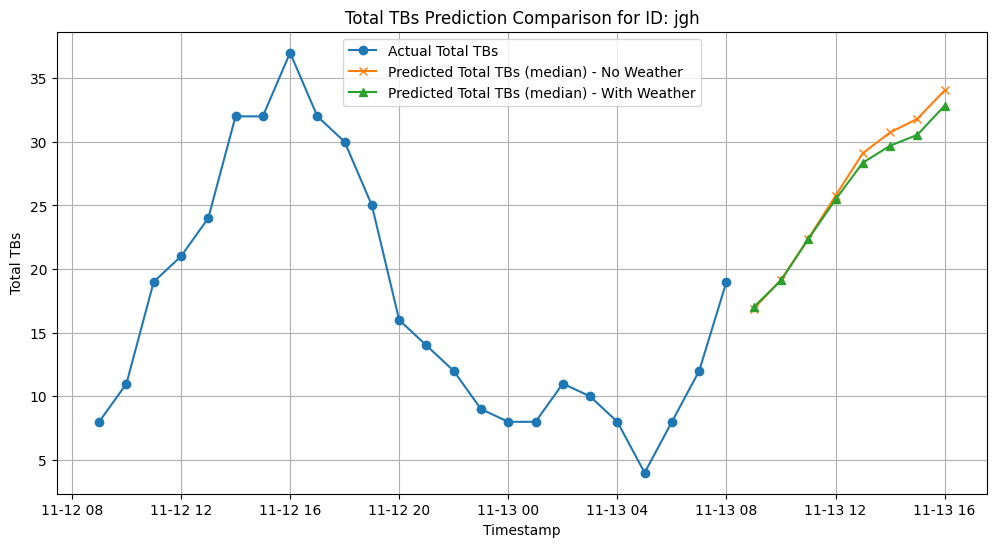

In [29]:
#plot both the prediction with weather and the prediction without weather for total_tbs
id_to_plot = "jgh"
# Without weather
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data_no_weather = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_no_weather = predicted_data_no_weather.sort_index()
# With weather
predicted_data_with_weather = pred_df_with_hist_weather[
    (pred_df_with_hist_weather[ID_COL] == id_to_plot) & (pred_df_with_hist_weather["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_with_weather = predicted_data_with_weather.sort_index()
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["total_tbs"][-24:], label="Actual Total TBs", marker="o")
# Plot the next 8 hours of predicted median (0.5) without weather
plt.plot(predicted_data_no_weather.index[:8], predicted_data_no_weather["0.5"][:8], label="Predicted Total TBs (median) - No Weather", marker="x")
# Plot the next 8 hours of predicted median (0.5) with weather
plt.plot(predicted_data_with_weather.index[:8], predicted_data_with_weather["0.5"][:8], label="Predicted Total TBs (median) - With Weather", marker="^")
plt.xlabel("Timestamp")
plt.ylabel("Total TBs")
plt.title(f"Total TBs Prediction Comparison for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()

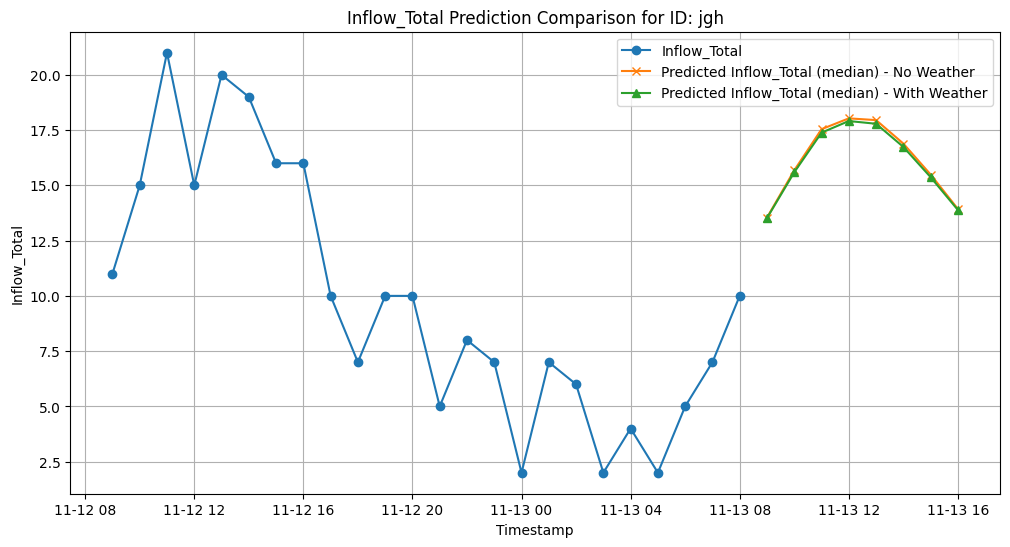

In [30]:
#plot both the prediction with weather and the prediction without weather for Inflow_Total
id_to_plot = "jgh"
# Without weather
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data_no_weather = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "Inflow_Total")
].set_index(TS_COL)
predicted_data_no_weather = predicted_data_no_weather.sort_index()
# With weather
predicted_data_with_weather = pred_df_with_hist_weather[
    (pred_df_with_hist_weather[ID_COL] == id_to_plot) & (pred_df_with_hist_weather["target_name"] == "Inflow_Total")
].set_index(TS_COL)
predicted_data_with_weather = predicted_data_with_weather.sort_index()
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["Inflow_Total"][-24:], label="Inflow_Total", marker="o")
# Plot the next 8 hours of predicted median (0.5) without weather
plt.plot(predicted_data_no_weather.index[:8], predicted_data_no_weather["0.5"][:8], label="Predicted Inflow_Total (median) - No Weather", marker="x")
# Plot the next 8 hours of predicted median (0.5) with weather
plt.plot(predicted_data_with_weather.index[:8], predicted_data_with_weather["0.5"][:8], label="Predicted Inflow_Total (median) - With Weather", marker="^")
plt.xlabel("Timestamp")
plt.ylabel("Inflow_Total")
plt.title(f"Inflow_Total Prediction Comparison for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()

In [51]:
hourly_shifts = pd.read_csv('https://www.dropbox.com/scl/fi/1ap6anzn5q13lcykh3idn/hourly_shifts.csv?rlkey=ue7nnfmrxij8keku8cgsrveo8&raw=1')
hourly_shifts.ds = pd.to_datetime(hourly_shifts.ds, errors="coerce")
hourly_shifts.tail()

/var/folders/fy/5x01qzld283cfjx15gg5tsp40000gn/T/ipykernel_3001/2502503029.py:1: DtypeWarning: Columns (8,26,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_shifts = pd.read_csv('https://www.dropbox.com/scl/fi/1ap6anzn5q13lcykh3idn/hourly_shifts.csv?rlkey=ue7nnfmrxij8keku8cgsrveo8&raw=1')


,ds,W1,X1,X3,X4,X2,WOC1,WOC2,WOC3,X5,...,N1,N2,L2,L4,H1,B1,L1,W5,L6,B2
42834,2025-11-21 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EmilyMoras,WayneChoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42835,2025-11-21 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EmilyMoras,WayneChoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42836,2025-11-21 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EmilyMoras,WayneChoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42837,2025-11-21 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EmilyMoras,WayneChoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42838,2025-11-21 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,EmilyMoras,WayneChoi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df_with_hist_hourly_shifts = pd.merge(df, hourly_shifts, on='ds', how='left')
df_with_hist_hourly_shifts.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,N1,N2,L2,L4,H1,B1,L1,W5,L6,B2
42656,2025-11-13 09:00:00,10.0,43.0,6.0,16.0,16.0,59.0,3.0,14.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42657,2025-11-13 10:00:00,14.0,57.0,8.0,24.0,22.0,81.0,1.0,15.0,0.0,...,NaN,NaN,NaN,NaN,NaN,DidierSerero,NaN,NaN,NaN,NaN
42658,2025-11-13 11:00:00,15.0,72.0,3.0,27.0,18.0,99.0,6.0,21.0,1.0,...,NaN,NaN,NaN,NaN,NaN,DidierSerero,NaN,NaN,NaN,NaN
42659,2025-11-13 12:00:00,16.0,88.0,6.0,33.0,22.0,121.0,2.0,23.0,1.0,...,NaN,NaN,NaN,NaN,NaN,DidierSerero,EliSegal,NaN,NaN,NaN
42660,2025-11-13 13:00:00,10.0,98.0,7.0,40.0,17.0,138.0,2.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,DidierSerero,EliSegal,NaN,NaN,NaN


In [41]:
predict_df_with_hist_hourly_shifts = pipeline.predict_df(
    df_with_hist_hourly_shifts,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
predict_df_with_hist_hourly_shifts.head()

,id,ds,target_name,predictions,0.1,0.5,0.9
0,jgh,2025-11-13 09:00:00,total_tbs,17.854765,14.488437,17.854765,20.901711
1,jgh,2025-11-13 10:00:00,total_tbs,20.282427,15.224868,20.282427,25.085234
2,jgh,2025-11-13 11:00:00,total_tbs,23.334164,16.568413,23.334164,30.343517
3,jgh,2025-11-13 12:00:00,total_tbs,26.876961,18.521624,26.876961,35.172932
4,jgh,2025-11-13 13:00:00,total_tbs,30.641525,20.994953,30.641525,40.340019


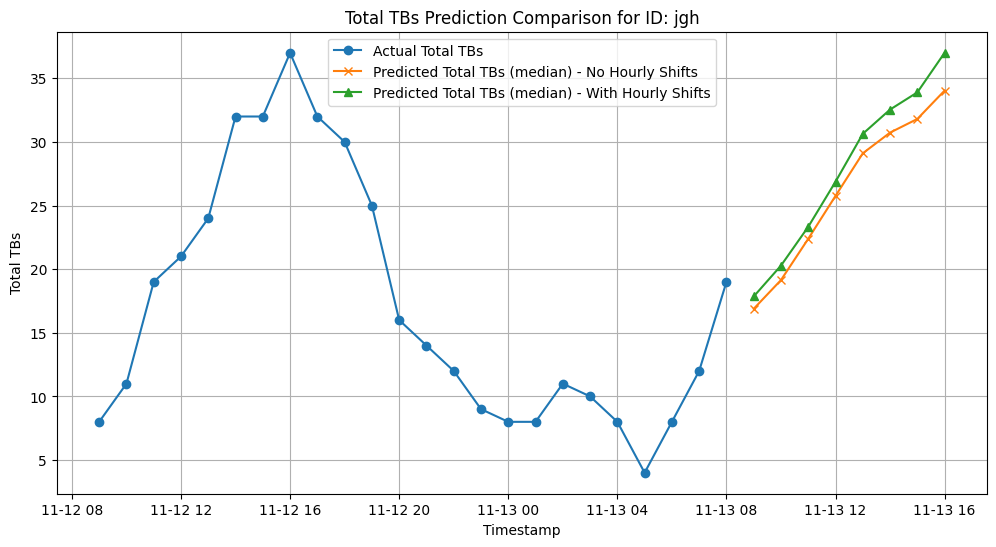

In [34]:
#plot both the prediction with hourly shifts and the prediction without hourly shifts for total_tbs
id_to_plot = "jgh"
# Without hourly shifts
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data_no_hourly_shifts = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_no_hourly_shifts = predicted_data_no_hourly_shifts.sort_index()
# With hourly shifts
predicted_data_with_hourly_shifts = predict_df_with_hist_hourly_shifts[
    (predict_df_with_hist_hourly_shifts[ID_COL] == id_to_plot) & (predict_df_with_hist_hourly_shifts["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_with_hourly_shifts = predicted_data_with_hourly_shifts.sort_index()
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["total_tbs"][-24:], label="Actual Total TBs", marker="o")
# Plot the next 8 hours of predicted median (0.5) without hourly shifts
plt.plot(predicted_data_no_hourly_shifts.index[:8], predicted_data_no_hourly_shifts["0.5"][:8], label="Predicted Total TBs (median) - No Hourly Shifts", marker="x")
# Plot the next 8 hours of predicted median (0.5) with hourly shifts
plt.plot(predicted_data_with_hourly_shifts.index[:8], predicted_data_with_hourly_shifts["0.5"][:8], label="Predicted Total TBs (median) - With Hourly Shifts", marker="^")
plt.xlabel("Timestamp")
plt.ylabel("Total TBs")
plt.title(f"Total TBs Prediction Comparison for ID: {id_to_plot}")
plt.legend()
plt.grid()
plt.show()

In [53]:
future_hourly_shifts_df = hourly_shifts[hourly_shifts['ds'] > df['ds'].max()].head(24)
future_hourly_shifts_df['id'] = 'jgh'
future_hourly_shifts_df.tail()


,ds,W1,X1,X3,X4,X2,WOC1,WOC2,WOC3,X5,...,N2,L2,L4,H1,B1,L1,W5,L6,B2,id
42673,2025-11-14 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jgh
42674,2025-11-14 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EmilyMoras,NaN,NaN,NaN,NaN,jgh
42675,2025-11-14 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EmilyMoras,NaN,NaN,NaN,NaN,jgh
42676,2025-11-14 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EmilyMoras,RafaelAroutiunian,NaN,NaN,NaN,jgh
42677,2025-11-14 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EmilyMoras,RafaelAroutiunian,NaN,NaN,NaN,jgh


In [54]:

predict_df_with_future_hourly_shifts = pipeline.predict_df(
    df_with_hist_hourly_shifts,
    future_df=future_hourly_shifts_df,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
predict_df_with_future_hourly_shifts.head()

,id,ds,target_name,predictions,0.1,0.5,0.9
0,jgh,2025-11-13 14:00:00,total_tbs,35.552818,29.817820,35.552818,41.491226
1,jgh,2025-11-13 15:00:00,total_tbs,36.028683,28.136353,36.028683,43.704880
2,jgh,2025-11-13 16:00:00,total_tbs,41.435799,32.178402,41.435799,50.048431
3,jgh,2025-11-13 17:00:00,total_tbs,36.767887,26.008928,36.767887,47.501991
4,jgh,2025-11-13 18:00:00,total_tbs,34.048523,22.260065,34.048523,46.036530


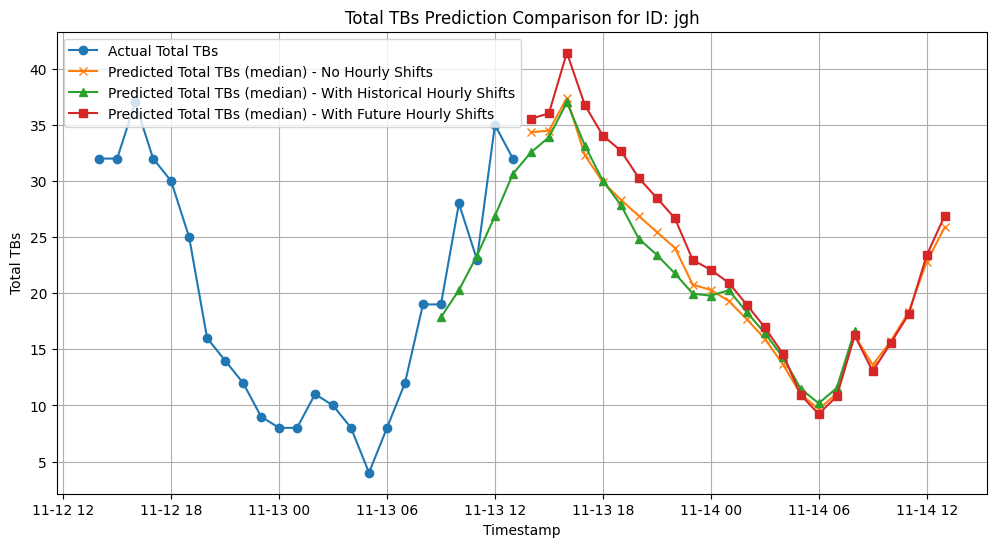

In [55]:
#plot the prediction with historical hourly shifts, the prediction with future hourly shifts, and the prediction without hourly shifts for total_tbs
id_to_plot = "jgh"
# Without hourly shifts
actual_data = df[df[ID_COL] == id_to_plot].set_index(TS_COL)
predicted_data_no_hourly_shifts = pred_df[
    (pred_df[ID_COL] == id_to_plot) & (pred_df["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_no_hourly_shifts = predicted_data_no_hourly_shifts.sort_index()
# With historical hourly shifts
predicted_data_with_hist_hourly_shifts = predict_df_with_hist_hourly_shifts[
    (predict_df_with_hist_hourly_shifts[ID_COL] == id_to_plot) & (predict_df_with_hist_hourly_shifts["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_with_hist_hourly_shifts = predicted_data_with_hist_hourly_shifts.sort_index()
# With future hourly shifts
predicted_data_with_future_hourly_shifts = predict_df_with_future_hourly_shifts[
    (predict_df_with_future_hourly_shifts[ID_COL] == id_to_plot) & (predict_df_with_future_hourly_shifts["target_name"] == "total_tbs")
].set_index(TS_COL)
predicted_data_with_future_hourly_shifts = predicted_data_with_future_hourly_shifts.sort_index()
# Plot the last 24 hours of actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data.index[-24:], actual_data["total_tbs"][-24:], label="Actual Total TBs", marker="o")
# Plot the next 24 hours of predicted median (0.5) without hourly shifts
plt.plot(predicted_data_no_hourly_shifts.index[:24], predicted_data_no_hourly_shifts["0.5"][:24], label="Predicted Total TBs (median) - No Hourly Shifts", marker="x")
# Plot the next 24 hours of predicted median (0.5) with historical hourly shifts
plt.plot(predicted_data_with_hist_hourly_shifts.index[:24], predicted_data_with_hist_hourly_shifts["0.5"][:24], label="Predicted Total TBs (median) - With Historical Hourly Shifts", marker="^")
# Plot the next 24 hours of predicted median (0.5) with future hourly shifts
plt.plot(predicted_data_with_future_hourly_shifts.index[:24], predicted_data_with_future_hourly_shifts["0.5"][:24], label="Predicted Total TBs (median) - With Future Hourly Shifts", marker="s")
plt.xlabel("Timestamp")
plt.ylabel("Total TBs")
plt.title(f"Total TBs Prediction Comparison for ID: {id_to_plot}")
plt.legend()
plt.grid()


In [64]:
df_with_weather_and_shifts = pd.merge(df_with_hist_hourly_shifts,metar_df, on='ds', how='left')
df_with_weather_and_shifts.tail()

,ds,INFLOW_STRETCHER,Infl_Stretcher_cum,INFLOW_AMBULATORY,Infl_Ambulatory_cum,Inflow_Total,Inflow_Cum_Total,INFLOW_AMBULANCES,Infl_Ambulances_cum,FLS,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,snowdepth
42689,2025-11-13 09:00:00,10.0,43.0,6.0,16.0,16.0,59.0,3.0,14.0,0.0,...,M,-SNRA,M,M,M,M,M,M,30.75,M
42690,2025-11-13 10:00:00,14.0,57.0,8.0,24.0,22.0,81.0,1.0,15.0,0.0,...,M,-SN,M,M,M,M,M,M,29.52,M
42691,2025-11-13 11:00:00,15.0,72.0,3.0,27.0,18.0,99.0,6.0,21.0,1.0,...,M,-SNRA,M,M,M,M,M,M,28.53,M
42692,2025-11-13 12:00:00,16.0,88.0,6.0,33.0,22.0,121.0,2.0,23.0,1.0,...,M,-DZ BR,M,M,M,M,M,M,27.99,M
42693,2025-11-13 13:00:00,10.0,98.0,7.0,40.0,17.0,138.0,2.0,25.0,0.0,...,M,-RA BR,M,M,M,M,M,M,29.17,M


In [65]:
predict_df_with_future_hourly_shifts = pipeline.predict_df(
    df_with_weather_and_shifts,
    future_df=future_hourly_shifts_df,
    prediction_length=24,
    quantile_levels=[0.1, 0.5, 0.9],
    id_column=ID_COL,
    timestamp_column=TS_COL,
    target=TARGETS,
)
predict_df_with_future_hourly_shifts.head()

ValueError: Could not infer frequency for series jgh